# Modeling the energy production and consumption

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout

import tensorflow as tf
tf.keras.utils.set_random_seed(1234)

### Loading data

In [2]:
DATA_FILE_PATH = 'solar_energy_data_clean.csv'
df = pd.read_csv(DATA_FILE_PATH)

In [9]:
df.head().T

,0,1,2,3,4
datetime,2021-09-08 00:00:00,2021-09-08 01:00:00,2021-09-08 02:00:00,2021-09-08 03:00:00,2021-09-08 04:00:00
target,0.0,0.0,0.0,0.0,0.0
eic_count,6.0,6.0,6.0,6.0,6.0
installed_capacity,324.2,324.2,324.2,324.2,324.2
temperature,14.586145,14.404932,14.233301,14.188745,14.884485
dewpoint,12.46792,12.962,13.118494,13.118677,13.389856
cloudcover_high,0.0,0.007896,0.392868,0.357033,0.370682
cloudcover_low,0.057953,0.062828,0.067619,0.124176,0.186813
cloudcover_mid,0.15033,0.02269,0.00351,0.000031,0.30896
cloudcover_total,0.185695,0.084471,0.425801,0.415109,0.584599


In [6]:
list(df.columns)

['datetime',
 'target',
 'eic_count',
 'installed_capacity',
 'temperature',
 'dewpoint',
 'cloudcover_high',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_total',
 '10_metre_u_wind_component',
 '10_metre_v_wind_component',
 'direct_solar_radiation',
 'surface_solar_radiation_downwards',
 'snowfall',
 'total_precipitation',
 'temperature_hist_1h',
 'dewpoint_hist_1h',
 'rain_hist_1h',
 'snowfall_hist_1h',
 'surface_pressure_hist_1h',
 'cloudcover_total_hist_1h',
 'cloudcover_low_hist_1h',
 'cloudcover_mid_hist_1h',
 'cloudcover_high_hist_1h',
 'windspeed_10m_hist_1h',
 'winddirection_10m_hist_1h',
 'shortwave_radiation_hist_1h',
 'direct_solar_radiation_hist_1h',
 'diffuse_radiation_hist_1h',
 'year',
 'month',
 'day',
 'weekday',
 'dayofyear',
 'hour',
 'sin_dayofyear',
 'cos_dayofyear',
 'sin_hour',
 'cos_hour',
 'target_1d_lag',
 'target_2d_lag',
 'target_3d_lag',
 'target_4d_lag',
 'target_5d_lag',
 'target_6d_lag',
 'target_7d_lag']

#### Defining target and features columns

In [14]:
target = 'target'

In [15]:
features = [
    # solar panels characteristics
    'eic_count',
    'installed_capacity',
    
    # weather forecast
    'temperature',
    'dewpoint',
    'cloudcover_high',
    'cloudcover_low',
    'cloudcover_mid',
    'cloudcover_total',
    '10_metre_u_wind_component',
    '10_metre_v_wind_component',
    'direct_solar_radiation',
    'surface_solar_radiation_downwards',
    'snowfall',
    'total_precipitation',
    
    # historical weather
    'temperature_hist_1h',
    'dewpoint_hist_1h',
    'rain_hist_1h',
    'snowfall_hist_1h',
    'surface_pressure_hist_1h',
    'cloudcover_total_hist_1h',
    'cloudcover_low_hist_1h',
    'cloudcover_mid_hist_1h',
    'cloudcover_high_hist_1h',
    'windspeed_10m_hist_1h',
    'winddirection_10m_hist_1h',
    'shortwave_radiation_hist_1h',
    'direct_solar_radiation_hist_1h',
    'diffuse_radiation_hist_1h',
    
    # date and time
    'year',
    'month',
    'weekday',
    'sin_dayofyear',
    'cos_dayofyear',
    'sin_hour',
    'cos_hour',
    
    # lags of energy production
    'target_1d_lag',
    'target_2d_lag',
    'target_3d_lag',
    'target_4d_lag',
    'target_5d_lag',
    'target_6d_lag',
    'target_7d_lag'
]

### Train, validation and test set split

In [16]:
def split__train_val_test_sets(df):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)
    
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.target.values
    y_val = df_val.target.values
    y_test = df_test.target.values
    
    del df_train['target']
    del df_val['target']
    del df_test['target']
    return df_train, df_test, df_val, y_train, y_test, y_val

In [17]:
df_train, df_test, df_val, y_train, y_test, y_val = split__train_val_test_sets(df)

In [18]:
X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

#### Scaling the data

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
print(scaler.mean_)

[ 1.11433775e+01  4.65752881e+02  5.66980302e+00  2.06492681e+00
  3.93881809e-01  4.25139845e-01  3.41498056e-01  6.68584260e-01
  8.05045663e-01  5.60826271e-01  1.53609660e+02  1.11508475e+02
  2.38715418e-05  8.02766000e-05  5.62069438e+00  2.12029180e+00
  4.85010644e-02  1.62330988e-02  1.00930687e+03  6.07129454e+01
  4.68224042e+01  3.42067989e+01  3.57854354e+01  4.83899160e+00
  1.95620461e+02  1.07289669e+02  6.52734223e+01  4.20162468e+01
  2.02205419e+03  6.40275938e+00  2.99403974e+00  4.26311011e-02
  1.32053182e-01  1.34657837e-04 -1.90507726e-03  9.95028642e+00
  9.78059978e+00  9.65117483e+00  9.56332969e+00  9.47544680e+00
  9.68442815e+00  9.66288411e+00]


In [20]:
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Training the first Neural Network

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [91]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

model = get_model(X_train_scaled.shape[1], 1)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 64)                2752      
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=1024,
    epochs=80,
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/80
9/9 [==============================] - 1s 18ms/step - loss: 256.8095 - mse: 256.8095 - val_loss: 139.5359 - val_mse: 139.5359
Epoch 2/80
9/9 [==============================] - 0s 6ms/step - loss: 124.5672 - mse: 124.5672 - val_loss: 109.5016 - val_mse: 109.5016
Epoch 3/80
9/9 [==============================] - 0s 6ms/step - loss: 97.0367 - mse: 97.0367 - val_loss: 104.2973 - val_mse: 104.2973
Epoch 4/80
9/9 [==============================] - 0s 5ms/step - loss: 88.6448 - mse: 88.6448 - val_loss: 96.9418 - val_mse: 96.9418
Epoch 5/80
9/9 [==============================] - 0s 6ms/step - loss: 83.9905 - mse: 83.9905 - val_loss: 92.5458 - val_mse: 92.5458
Epoch 6/80
9/9 [==============================] - 0s 5ms/step - loss: 80.1511 - mse: 80.1511 - val_loss: 88.3301 - val_mse: 88.3301
Epoch 7/80
9/9 [==============================] - 0s 5ms/step - loss: 76.3620 - mse: 76.3620 - val_loss: 86.3724 - val_mse: 86.3724
Epoch 8/80
9/9 [==============================] - 0s 5ms/step - l

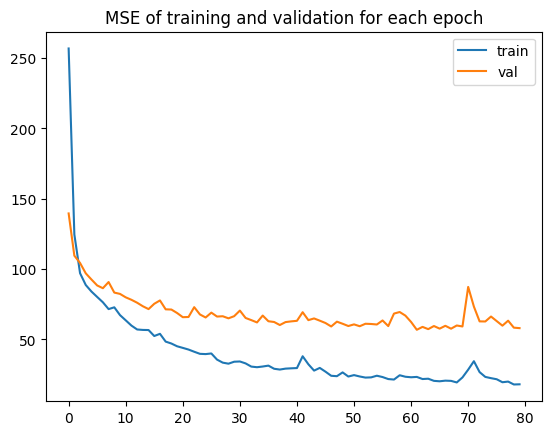

In [93]:
plt.plot(history.history['mse'], label='train');
plt.plot(history.history['val_mse'], label='val');
plt.title('MSE of training and validation for each epoch');
plt.legend();

In [95]:
# Average MSE of last five epochs
MSE_avg = sum(history.history['val_mse'][-5:]) / 5
MSE_avg

60.46396102905273

##### Summary:
- **MSE-val** values stabilize from about 60th epoch so we won't improve the model by training it longer.
- We will try adding one more layer.

## Adding inner layer

In [96]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

model = get_model(X_train_scaled.shape[1], 1)

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 64)                2752      
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4865 (19.00 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=1024,
    epochs=80,
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/80
9/9 [==============================] - 1s 19ms/step - loss: 304.5212 - mse: 304.5212 - val_loss: 130.4108 - val_mse: 130.4108
Epoch 2/80
9/9 [==============================] - 0s 10ms/step - loss: 112.8012 - mse: 112.8012 - val_loss: 113.3479 - val_mse: 113.3479
Epoch 3/80
9/9 [==============================] - 0s 8ms/step - loss: 92.2223 - mse: 92.2223 - val_loss: 103.0946 - val_mse: 103.0946
Epoch 4/80
9/9 [==============================] - 0s 7ms/step - loss: 88.1150 - mse: 88.1150 - val_loss: 90.6547 - val_mse: 90.6547
Epoch 5/80
9/9 [==============================] - 0s 6ms/step - loss: 77.4737 - mse: 77.4737 - val_loss: 86.0747 - val_mse: 86.0747
Epoch 6/80
9/9 [==============================] - 0s 6ms/step - loss: 71.5798 - mse: 71.5798 - val_loss: 84.8119 - val_mse: 84.8119
Epoch 7/80
9/9 [==============================] - 0s 6ms/step - loss: 70.7118 - mse: 70.7118 - val_loss: 78.6102 - val_mse: 78.6102
Epoch 8/80
9/9 [==============================] - 0s 8ms/step - 

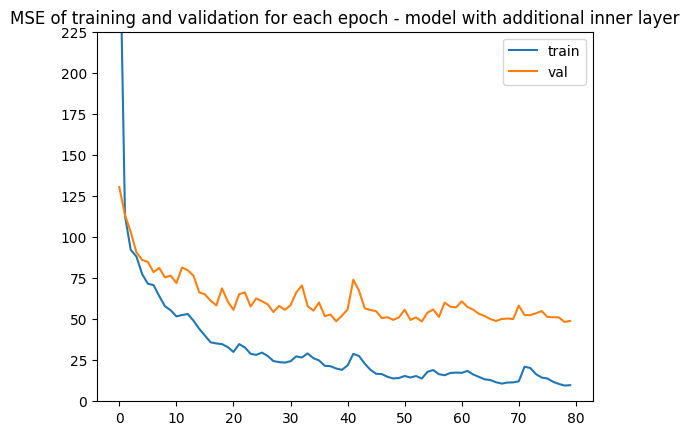

In [98]:
plt.plot(history.history['mse'], label='train');
plt.plot(history.history['val_mse'], label='val');
plt.ylim([0, 225]);
plt.title('MSE of training and validation for each epoch - model with additional inner layer');
plt.legend();

In [99]:
# Average MSE of last five epochs
MSE_avg = sum(history.history['val_mse'][-5:]) / 5
MSE_avg

50.171136474609376

#### Summary:
- Adding additional layer **helped** with decreasing MSE-val from about 60 to 50.
- We will continue now with this model and **tune learning rate** and **the size of the inner layer**.

## Adjusting the Learning Rate

https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/08-deep-learning/notebook.ipynb

In [100]:
def get_model(n_inputs, n_outputs, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

In [114]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = get_model(X_train_scaled.shape[1], 1, learning_rate=lr)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=1024,
        epochs=200,
        validation_data=(X_val_scaled, y_val),
        verbose=0
    )
    scores[lr] = history.history

    print()
    print()

0.0001


0.001


0.01


0.1




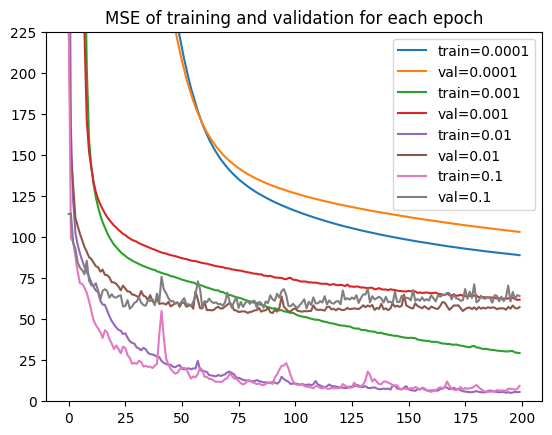

In [116]:
for lr, hist in scores.items():
    plt.plot(hist['mse'], label=('train=%s' % lr));
    plt.plot(hist['val_mse'], label=('val=%s' % lr));
plt.ylim([0, 225]);
plt.title('MSE of training and validation for each epoch');
plt.legend();

In [132]:
# Average MSE of last five epochs
MSE_avg = sum(scores[0.01]['val_mse'][-5:]) / 5
MSE_avg

57.06099624633789

#### Summary
- Learning rates of 0.0001 and 0.001 make the model learn too slow.
- Learning rates of 0.01 and 0.1 give similar results however with 0.1 values are not smooth.
- The best value of **learning rate** for our model: **0.01**.

### Tuning the size of an inner layer

In [137]:
def get_model(n_inputs, n_outputs, learning_rate=0.01, size=32):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(size, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

In [138]:
scores = {}
lr = 0.01

for s in [16, 32, 64, 128, 256]:
    print(s)

    model = get_model(X_train_scaled.shape[1], 1, learning_rate=lr, size=s)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=1024,
        epochs=200,
        validation_data=(X_val_scaled, y_val),
        verbose=0
    )
    scores[s] = history.history

    print()
    print()

16


32


64


128


256




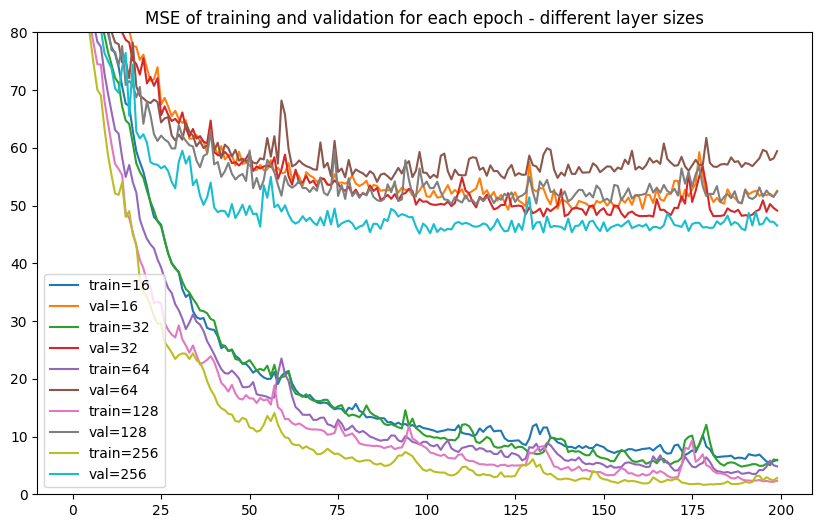

In [140]:
plt.figure(figsize=(10,6));
for s, hist in scores.items():
    plt.plot(hist['mse'], label=('train=%s' % s));
    plt.plot(hist['val_mse'], label=('val=%s' % s));
plt.title('MSE of training and validation for each epoch - different layer sizes');
plt.ylim([0,80]);
plt.legend();

In [ ]:
# Average MSE of last five epochs
MSE_avg = sum(scores[256]['val_mse'][-5:]) / 5
MSE_avg

#### Summary
- The larger the layer the lower the MSE for training and validation sets.
- We choose the **size-256** for the inner layer.

### Adding dropout

In [160]:
def get_model(n_inputs, n_outputs, learning_rate=0.01, size=32, droprate=0.5):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(size, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(rate=droprate))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

In [151]:
learning_rate = 0.01
size = 256

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = get_model(X_train_scaled.shape[1], 1, learning_rate=learning_rate, size=size, droprate=droprate)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=1024,
        epochs=200,
        validation_data=(X_val_scaled, y_val),
        verbose=0
    )
    scores[droprate] = history.history

    print()
    print()

0.0


0.2


0.5


0.8




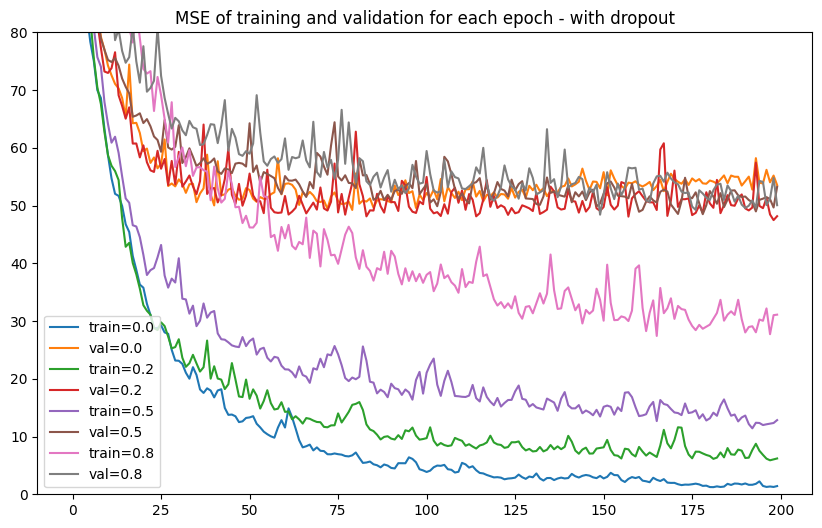

In [153]:
plt.figure(figsize=(10,6));
for s, hist in scores.items():
    plt.plot(hist['mse'], label=('train=%s' % s));
    plt.plot(hist['val_mse'], label=('val=%s' % s));
plt.title('MSE of training and validation for each epoch - with dropout');
plt.ylim([0,80]);
plt.legend();

In [158]:
MSE_avg_0_0 = sum(scores[0.0]['val_mse'][-50:]) / 50
MSE_avg_0_0

54.20801445007324

In [155]:
MSE_avg_0_2 = sum(scores[0.2]['val_mse'][-50:]) / 50
MSE_avg_0_2

51.0479621887207

In [156]:
MSE_avg_0_5 = sum(scores[0.5]['val_mse'][-50:]) / 50
MSE_avg_0_5

51.332190628051755

In [157]:
MSE_avg_0_8 = sum(scores[0.8]['val_mse'][-50:]) / 50
MSE_avg_0_8

52.605650177001955

#### Summary
- Adding a small **dropout (rate=0.2)** is the best choice.

### Checkpointing

In [210]:
# 'xception_v1_{epoch:02d}_{val_mse:.3f}.h5'
# UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

chechpoint = keras.callbacks.ModelCheckpoint(
    'model_solar_energy_production.keras',
    # 'model_ckpt_v1_{epoch:02d}_{val_mse:.3f}.keras',
    save_best_only=True,
    monitor='val_mse',
    mode='min'
)

lr = 0.01
s = 256
dr = 0.2
model = get_model(X_train_scaled.shape[1], 1, learning_rate=lr, size=s, droprate=dr)

history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=1024,
    epochs=60,
    validation_data=(X_val_scaled, y_val),
    # verbose=0,
    callbacks=[chechpoint]
)

Epoch 1/60
9/9 [==============================] - 1s 24ms/step - loss: 319.7754 - mse: 319.7754 - val_loss: 136.4722 - val_mse: 136.4722
Epoch 2/60
9/9 [==============================] - 0s 14ms/step - loss: 121.5583 - mse: 121.5583 - val_loss: 127.0117 - val_mse: 127.0117
Epoch 3/60
9/9 [==============================] - 0s 12ms/step - loss: 101.8974 - mse: 101.8974 - val_loss: 106.4369 - val_mse: 106.4369
Epoch 4/60
9/9 [==============================] - 0s 14ms/step - loss: 90.8343 - mse: 90.8343 - val_loss: 97.8613 - val_mse: 97.8613
Epoch 5/60
9/9 [==============================] - 0s 19ms/step - loss: 84.2839 - mse: 84.2839 - val_loss: 94.0537 - val_mse: 94.0537
Epoch 6/60
9/9 [==============================] - 0s 16ms/step - loss: 81.9994 - mse: 81.9994 - val_loss: 88.8605 - val_mse: 88.8605
Epoch 7/60
9/9 [==============================] - 0s 12ms/step - loss: 76.3007 - mse: 76.3007 - val_loss: 85.9101 - val_mse: 85.9101
Epoch 8/60
9/9 [==============================] - 0s 8ms/

### Test

In [215]:
model.evaluate(x=X_test_scaled,y=y_test)

95/95 [==============================] - 0s 1ms/step - loss: 43.4949 - mse: 43.4949


[43.49492263793945, 43.49492263793945]

#### Plotting test predictions

In [216]:
predictions = model.predict(X_test_scaled)
y_pred = predictions.reshape(-1)

mse = mean_squared_error(y_pred, y_test)
mse

95/95 [==============================] - 0s 2ms/step


43.494916173364686

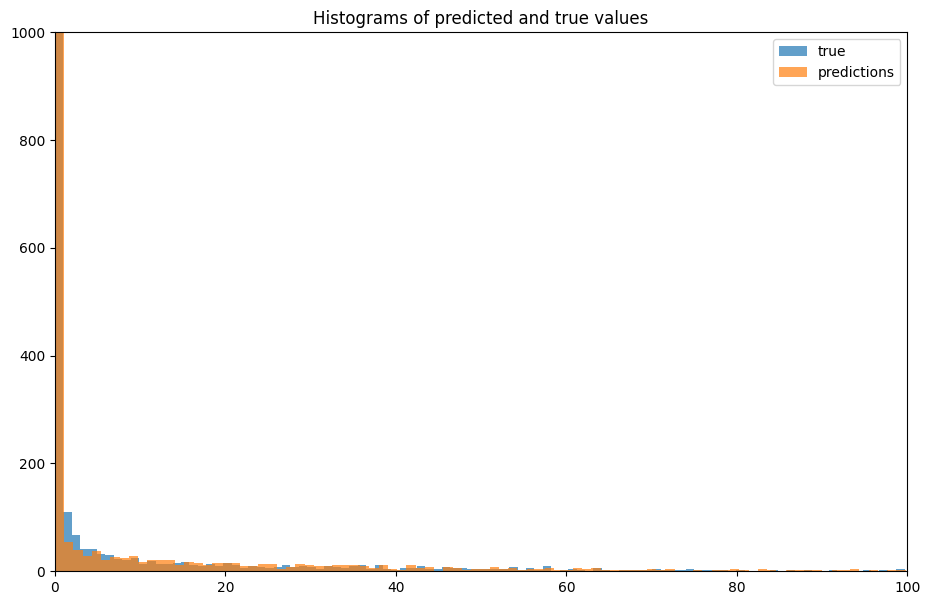

In [217]:
plt.figure(figsize=(11,7))
_ = plt.hist(y_test, bins=200, alpha=0.7, label="true") 
_ = plt.hist(y_pred, bins=200, alpha=0.7, label="predictions")
plt.title("Histograms of predicted and true values")
plt.xlim([0, 100])
plt.ylim([0, 1000])
plt.legend()
plt.show()

#### Summary
- The MSE of the Test set is on the same level as on Validation set so the model is trained well and can be used in production. 